# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.GELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.GELU(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 100, 100, 100, 100, 100, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=100, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 100, 100, 100, 100, 100, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9174
Epoch 1/200, Iteration 2/12, Loss: 1.1263
Epoch 1/200, Iteration 3/12, Loss: 0.6590
Epoch 1/200, Iteration 4/12, Loss: 0.4291
Epoch 1/200, Iteration 5/12, Loss: 0.2598
Epoch 1/200, Iteration 6/12, Loss: 0.1969
Epoch 1/200, Iteration 7/12, Loss: 0.1540
Epoch 1/200, Iteration 8/12, Loss: 0.2144
Epoch 1/200, Iteration 9/12, Loss: 0.1418
Epoch 1/200, Iteration 10/12, Loss: 0.1459
Epoch 1/200, Iteration 11/12, Loss: 0.0861
Epoch 1/200, Iteration 12/12, Loss: 0.0803
Epoch 1/200, Iteration 13/12, Loss: 0.1180
Train Error: 
 Accuracy: 65.0%, Avg loss: 0.110563, MRE: 0.184976, MAE: 0.039178 

Test Error: 
 Accuracy: 64.5%, Avg loss: 0.138437, MRE: 0.166678, MAE: 0.045448 

Epoch 2/200, Iteration 1/12, Loss: 0.1230
Epoch 2/200, Iteration 2/12, Loss: 0.0747
Epoch 2/200, Iteration 3/12, Loss: 0.0567
Epoch 2/200, Iteration 4/12, Loss: 0.0716
Epoch 2/200, Iteration 5/12, Loss: 0.0923
Epoch 2/200, Iteration 6/12, Loss: 0.0387
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.004252, MRE: 0.029199, MAE: 0.007168 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.003495, MRE: 0.026717, MAE: 0.007018 

Epoch 13/200, Iteration 1/12, Loss: 0.0040
Epoch 13/200, Iteration 2/12, Loss: 0.0015
Epoch 13/200, Iteration 3/12, Loss: 0.0049
Epoch 13/200, Iteration 4/12, Loss: 0.0019
Epoch 13/200, Iteration 5/12, Loss: 0.0021
Epoch 13/200, Iteration 6/12, Loss: 0.0018
Epoch 13/200, Iteration 7/12, Loss: 0.0010
Epoch 13/200, Iteration 8/12, Loss: 0.0018
Epoch 13/200, Iteration 9/12, Loss: 0.0011
Epoch 13/200, Iteration 10/12, Loss: 0.0017
Epoch 13/200, Iteration 11/12, Loss: 0.0009
Epoch 13/200, Iteration 12/12, Loss: 0.0058
Epoch 13/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.008249, MRE: 0.033306, MAE: 0.008185 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006394, MRE: 0.026556, MAE: 0.007810 

Epoch 14/200, Iteration 1/12, Loss: 0.0078
Epoch 14/200, Iteration 2/12, Loss: 0.0042
Epoch 14/200, Itera

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.000317, MRE: 0.008935, MAE: 0.001584 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000288, MRE: 0.008102, MAE: 0.001660 

Epoch 25/200, Iteration 1/12, Loss: 0.0004
Epoch 25/200, Iteration 2/12, Loss: 0.0003
Epoch 25/200, Iteration 3/12, Loss: 0.0003
Epoch 25/200, Iteration 4/12, Loss: 0.0005
Epoch 25/200, Iteration 5/12, Loss: 0.0004
Epoch 25/200, Iteration 6/12, Loss: 0.0004
Epoch 25/200, Iteration 7/12, Loss: 0.0002
Epoch 25/200, Iteration 8/12, Loss: 0.0002
Epoch 25/200, Iteration 9/12, Loss: 0.0004
Epoch 25/200, Iteration 10/12, Loss: 0.0002
Epoch 25/200, Iteration 11/12, Loss: 0.0003
Epoch 25/200, Iteration 12/12, Loss: 0.0004
Epoch 25/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000321, MRE: 0.009380, MAE: 0.001611 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000290, MRE: 0.007813, MAE: 0.001613 

Epoch 26/200, Iteration 1/12, Loss: 0.0005
Epoch 26/200, Iteration 2/12, Loss: 0.0002
Epoch 26/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000215, MRE: 0.008426, MAE: 0.001255 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000192, MRE: 0.006103, MAE: 0.001316 

Epoch 37/200, Iteration 1/12, Loss: 0.0003
Epoch 37/200, Iteration 2/12, Loss: 0.0003
Epoch 37/200, Iteration 3/12, Loss: 0.0001
Epoch 37/200, Iteration 4/12, Loss: 0.0002
Epoch 37/200, Iteration 5/12, Loss: 0.0001
Epoch 37/200, Iteration 6/12, Loss: 0.0003
Epoch 37/200, Iteration 7/12, Loss: 0.0002
Epoch 37/200, Iteration 8/12, Loss: 0.0001
Epoch 37/200, Iteration 9/12, Loss: 0.0003
Epoch 37/200, Iteration 10/12, Loss: 0.0002
Epoch 37/200, Iteration 11/12, Loss: 0.0002
Epoch 37/200, Iteration 12/12, Loss: 0.0001
Epoch 37/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000183, MRE: 0.007634, MAE: 0.001152 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000184, MRE: 0.006066, MAE: 0.001275 

Epoch 38/200, Iteration 1/12, Loss: 0.0003
Epoch 38/200, Iteration 2/12, Loss: 0.0001
Epoch 38/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000165, MRE: 0.007808, MAE: 0.001058 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000134, MRE: 0.005574, MAE: 0.001126 

Epoch 49/200, Iteration 1/12, Loss: 0.0002
Epoch 49/200, Iteration 2/12, Loss: 0.0002
Epoch 49/200, Iteration 3/12, Loss: 0.0001
Epoch 49/200, Iteration 4/12, Loss: 0.0001
Epoch 49/200, Iteration 5/12, Loss: 0.0002
Epoch 49/200, Iteration 6/12, Loss: 0.0003
Epoch 49/200, Iteration 7/12, Loss: 0.0001
Epoch 49/200, Iteration 8/12, Loss: 0.0002
Epoch 49/200, Iteration 9/12, Loss: 0.0002
Epoch 49/200, Iteration 10/12, Loss: 0.0001
Epoch 49/200, Iteration 11/12, Loss: 0.0004
Epoch 49/200, Iteration 12/12, Loss: 0.0003
Epoch 49/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000164, MRE: 0.007755, MAE: 0.001104 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000152, MRE: 0.005413, MAE: 0.001123 

Epoch 50/200, Iteration 1/12, Loss: 0.0001
Epoch 50/200, Iteration 2/12, Loss: 0.0004
Epoch 50/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000122, MRE: 0.007723, MAE: 0.001027 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000119, MRE: 0.005514, MAE: 0.001133 

Epoch 61/200, Iteration 1/12, Loss: 0.0001
Epoch 61/200, Iteration 2/12, Loss: 0.0001
Epoch 61/200, Iteration 3/12, Loss: 0.0001
Epoch 61/200, Iteration 4/12, Loss: 0.0001
Epoch 61/200, Iteration 5/12, Loss: 0.0001
Epoch 61/200, Iteration 6/12, Loss: 0.0001
Epoch 61/200, Iteration 7/12, Loss: 0.0001
Epoch 61/200, Iteration 8/12, Loss: 0.0002
Epoch 61/200, Iteration 9/12, Loss: 0.0002
Epoch 61/200, Iteration 10/12, Loss: 0.0002
Epoch 61/200, Iteration 11/12, Loss: 0.0002
Epoch 61/200, Iteration 12/12, Loss: 0.0001
Epoch 61/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000148, MRE: 0.007957, MAE: 0.001040 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000131, MRE: 0.005153, MAE: 0.001030 

Epoch 62/200, Iteration 1/12, Loss: 0.0002
Epoch 62/200, Iteration 2/12, Loss: 0.0001
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000121, MRE: 0.007027, MAE: 0.000942 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000107, MRE: 0.004996, MAE: 0.001011 

Epoch 73/200, Iteration 1/12, Loss: 0.0001
Epoch 73/200, Iteration 2/12, Loss: 0.0002
Epoch 73/200, Iteration 3/12, Loss: 0.0001
Epoch 73/200, Iteration 4/12, Loss: 0.0001
Epoch 73/200, Iteration 5/12, Loss: 0.0001
Epoch 73/200, Iteration 6/12, Loss: 0.0002
Epoch 73/200, Iteration 7/12, Loss: 0.0003
Epoch 73/200, Iteration 8/12, Loss: 0.0001
Epoch 73/200, Iteration 9/12, Loss: 0.0001
Epoch 73/200, Iteration 10/12, Loss: 0.0001
Epoch 73/200, Iteration 11/12, Loss: 0.0002
Epoch 73/200, Iteration 12/12, Loss: 0.0001
Epoch 73/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000109, MRE: 0.007015, MAE: 0.000932 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000097, MRE: 0.004777, MAE: 0.000939 

Epoch 74/200, Iteration 1/12, Loss: 0.0001
Epoch 74/200, Iteration 2/12, Loss: 0.0001
Epoch 74/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.006425, MAE: 0.000768 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000079, MRE: 0.004298, MAE: 0.000838 

Epoch 85/200, Iteration 1/12, Loss: 0.0001
Epoch 85/200, Iteration 2/12, Loss: 0.0001
Epoch 85/200, Iteration 3/12, Loss: 0.0000
Epoch 85/200, Iteration 4/12, Loss: 0.0001
Epoch 85/200, Iteration 5/12, Loss: 0.0001
Epoch 85/200, Iteration 6/12, Loss: 0.0001
Epoch 85/200, Iteration 7/12, Loss: 0.0001
Epoch 85/200, Iteration 8/12, Loss: 0.0001
Epoch 85/200, Iteration 9/12, Loss: 0.0001
Epoch 85/200, Iteration 10/12, Loss: 0.0001
Epoch 85/200, Iteration 11/12, Loss: 0.0001
Epoch 85/200, Iteration 12/12, Loss: 0.0001
Epoch 85/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000078, MRE: 0.006400, MAE: 0.000772 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000077, MRE: 0.004254, MAE: 0.000829 

Epoch 86/200, Iteration 1/12, Loss: 0.0001
Epoch 86/200, Iteration 2/12, Loss: 0.0001
Epoch 86/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000073, MRE: 0.006372, MAE: 0.000754 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000076, MRE: 0.004195, MAE: 0.000814 

Epoch 97/200, Iteration 1/12, Loss: 0.0000
Epoch 97/200, Iteration 2/12, Loss: 0.0000
Epoch 97/200, Iteration 3/12, Loss: 0.0001
Epoch 97/200, Iteration 4/12, Loss: 0.0001
Epoch 97/200, Iteration 5/12, Loss: 0.0001
Epoch 97/200, Iteration 6/12, Loss: 0.0001
Epoch 97/200, Iteration 7/12, Loss: 0.0001
Epoch 97/200, Iteration 8/12, Loss: 0.0000
Epoch 97/200, Iteration 9/12, Loss: 0.0001
Epoch 97/200, Iteration 10/12, Loss: 0.0001
Epoch 97/200, Iteration 11/12, Loss: 0.0001
Epoch 97/200, Iteration 12/12, Loss: 0.0001
Epoch 97/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000074, MRE: 0.006465, MAE: 0.000758 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.004199, MAE: 0.000820 

Epoch 98/200, Iteration 1/12, Loss: 0.0001
Epoch 98/200, Iteration 2/12, Loss: 0.0000
Epoch 98/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.006317, MAE: 0.000756 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000076, MRE: 0.004204, MAE: 0.000813 

Epoch 109/200, Iteration 1/12, Loss: 0.0000
Epoch 109/200, Iteration 2/12, Loss: 0.0001
Epoch 109/200, Iteration 3/12, Loss: 0.0001
Epoch 109/200, Iteration 4/12, Loss: 0.0002
Epoch 109/200, Iteration 5/12, Loss: 0.0001
Epoch 109/200, Iteration 6/12, Loss: 0.0000
Epoch 109/200, Iteration 7/12, Loss: 0.0000
Epoch 109/200, Iteration 8/12, Loss: 0.0001
Epoch 109/200, Iteration 9/12, Loss: 0.0001
Epoch 109/200, Iteration 10/12, Loss: 0.0001
Epoch 109/200, Iteration 11/12, Loss: 0.0001
Epoch 109/200, Iteration 12/12, Loss: 0.0001
Epoch 109/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000072, MRE: 0.006317, MAE: 0.000743 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000073, MRE: 0.004173, MAE: 0.000813 

Epoch 110/200, Iteration 1/12, Loss: 0.0001
Epoch 110/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000070, MRE: 0.006336, MAE: 0.000749 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.004240, MAE: 0.000822 

Epoch 121/200, Iteration 1/12, Loss: 0.0001
Epoch 121/200, Iteration 2/12, Loss: 0.0001
Epoch 121/200, Iteration 3/12, Loss: 0.0001
Epoch 121/200, Iteration 4/12, Loss: 0.0001
Epoch 121/200, Iteration 5/12, Loss: 0.0001
Epoch 121/200, Iteration 6/12, Loss: 0.0001
Epoch 121/200, Iteration 7/12, Loss: 0.0001
Epoch 121/200, Iteration 8/12, Loss: 0.0001
Epoch 121/200, Iteration 9/12, Loss: 0.0000
Epoch 121/200, Iteration 10/12, Loss: 0.0001
Epoch 121/200, Iteration 11/12, Loss: 0.0001
Epoch 121/200, Iteration 12/12, Loss: 0.0001
Epoch 121/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.006360, MAE: 0.000737 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000072, MRE: 0.004114, MAE: 0.000801 

Epoch 122/200, Iteration 1/12, Loss: 0.0000
Epoch 122/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000068, MRE: 0.006229, MAE: 0.000727 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000071, MRE: 0.004099, MAE: 0.000791 

Epoch 133/200, Iteration 1/12, Loss: 0.0001
Epoch 133/200, Iteration 2/12, Loss: 0.0001
Epoch 133/200, Iteration 3/12, Loss: 0.0001
Epoch 133/200, Iteration 4/12, Loss: 0.0001
Epoch 133/200, Iteration 5/12, Loss: 0.0001
Epoch 133/200, Iteration 6/12, Loss: 0.0001
Epoch 133/200, Iteration 7/12, Loss: 0.0000
Epoch 133/200, Iteration 8/12, Loss: 0.0001
Epoch 133/200, Iteration 9/12, Loss: 0.0001
Epoch 133/200, Iteration 10/12, Loss: 0.0001
Epoch 133/200, Iteration 11/12, Loss: 0.0001
Epoch 133/200, Iteration 12/12, Loss: 0.0001
Epoch 133/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000068, MRE: 0.006245, MAE: 0.000722 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000069, MRE: 0.004062, MAE: 0.000785 

Epoch 134/200, Iteration 1/12, Loss: 0.0001
Epoch 134/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.006248, MAE: 0.000722 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000070, MRE: 0.004115, MAE: 0.000790 

Epoch 145/200, Iteration 1/12, Loss: 0.0001
Epoch 145/200, Iteration 2/12, Loss: 0.0001
Epoch 145/200, Iteration 3/12, Loss: 0.0001
Epoch 145/200, Iteration 4/12, Loss: 0.0000
Epoch 145/200, Iteration 5/12, Loss: 0.0000
Epoch 145/200, Iteration 6/12, Loss: 0.0001
Epoch 145/200, Iteration 7/12, Loss: 0.0000
Epoch 145/200, Iteration 8/12, Loss: 0.0000
Epoch 145/200, Iteration 9/12, Loss: 0.0001
Epoch 145/200, Iteration 10/12, Loss: 0.0001
Epoch 145/200, Iteration 11/12, Loss: 0.0001
Epoch 145/200, Iteration 12/12, Loss: 0.0001
Epoch 145/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.006179, MAE: 0.000714 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000068, MRE: 0.004028, MAE: 0.000775 

Epoch 146/200, Iteration 1/12, Loss: 0.0001
Epoch 146/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.006260, MAE: 0.000715 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000067, MRE: 0.004012, MAE: 0.000776 

Epoch 157/200, Iteration 1/12, Loss: 0.0001
Epoch 157/200, Iteration 2/12, Loss: 0.0001
Epoch 157/200, Iteration 3/12, Loss: 0.0001
Epoch 157/200, Iteration 4/12, Loss: 0.0001
Epoch 157/200, Iteration 5/12, Loss: 0.0000
Epoch 157/200, Iteration 6/12, Loss: 0.0000
Epoch 157/200, Iteration 7/12, Loss: 0.0001
Epoch 157/200, Iteration 8/12, Loss: 0.0001
Epoch 157/200, Iteration 9/12, Loss: 0.0001
Epoch 157/200, Iteration 10/12, Loss: 0.0000
Epoch 157/200, Iteration 11/12, Loss: 0.0001
Epoch 157/200, Iteration 12/12, Loss: 0.0001
Epoch 157/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.006366, MAE: 0.000722 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000070, MRE: 0.004086, MAE: 0.000782 

Epoch 158/200, Iteration 1/12, Loss: 0.0001
Epoch 158/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000062, MRE: 0.006114, MAE: 0.000693 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000065, MRE: 0.003954, MAE: 0.000762 

Epoch 169/200, Iteration 1/12, Loss: 0.0001
Epoch 169/200, Iteration 2/12, Loss: 0.0001
Epoch 169/200, Iteration 3/12, Loss: 0.0001
Epoch 169/200, Iteration 4/12, Loss: 0.0000
Epoch 169/200, Iteration 5/12, Loss: 0.0001
Epoch 169/200, Iteration 6/12, Loss: 0.0000
Epoch 169/200, Iteration 7/12, Loss: 0.0001
Epoch 169/200, Iteration 8/12, Loss: 0.0000
Epoch 169/200, Iteration 9/12, Loss: 0.0000
Epoch 169/200, Iteration 10/12, Loss: 0.0001
Epoch 169/200, Iteration 11/12, Loss: 0.0000
Epoch 169/200, Iteration 12/12, Loss: 0.0001
Epoch 169/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.006179, MAE: 0.000701 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000066, MRE: 0.004031, MAE: 0.000765 

Epoch 170/200, Iteration 1/12, Loss: 0.0001
Epoch 170/200, Iteration 2/12, Loss: 0.0001
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000061, MRE: 0.006020, MAE: 0.000686 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000063, MRE: 0.003916, MAE: 0.000743 

Epoch 181/200, Iteration 1/12, Loss: 0.0000
Epoch 181/200, Iteration 2/12, Loss: 0.0001
Epoch 181/200, Iteration 3/12, Loss: 0.0001
Epoch 181/200, Iteration 4/12, Loss: 0.0001
Epoch 181/200, Iteration 5/12, Loss: 0.0000
Epoch 181/200, Iteration 6/12, Loss: 0.0000
Epoch 181/200, Iteration 7/12, Loss: 0.0000
Epoch 181/200, Iteration 8/12, Loss: 0.0001
Epoch 181/200, Iteration 9/12, Loss: 0.0001
Epoch 181/200, Iteration 10/12, Loss: 0.0001
Epoch 181/200, Iteration 11/12, Loss: 0.0001
Epoch 181/200, Iteration 12/12, Loss: 0.0001
Epoch 181/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.006077, MAE: 0.000685 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.003944, MAE: 0.000754 

Epoch 182/200, Iteration 1/12, Loss: 0.0000
Epoch 182/200, Iteration 2/12, Loss: 0.0000
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000059, MRE: 0.005979, MAE: 0.000671 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000061, MRE: 0.003909, MAE: 0.000744 

Epoch 193/200, Iteration 1/12, Loss: 0.0001
Epoch 193/200, Iteration 2/12, Loss: 0.0001
Epoch 193/200, Iteration 3/12, Loss: 0.0001
Epoch 193/200, Iteration 4/12, Loss: 0.0000
Epoch 193/200, Iteration 5/12, Loss: 0.0001
Epoch 193/200, Iteration 6/12, Loss: 0.0000
Epoch 193/200, Iteration 7/12, Loss: 0.0001
Epoch 193/200, Iteration 8/12, Loss: 0.0000
Epoch 193/200, Iteration 9/12, Loss: 0.0001
Epoch 193/200, Iteration 10/12, Loss: 0.0000
Epoch 193/200, Iteration 11/12, Loss: 0.0001
Epoch 193/200, Iteration 12/12, Loss: 0.0001
Epoch 193/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000060, MRE: 0.005996, MAE: 0.000674 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000062, MRE: 0.003898, MAE: 0.000733 

Epoch 194/200, Iteration 1/12, Loss: 0.0001
Epoch 194/200, Iteration 2/12, Loss: 0.0001
Ep

#### Plots loss vs Epoch

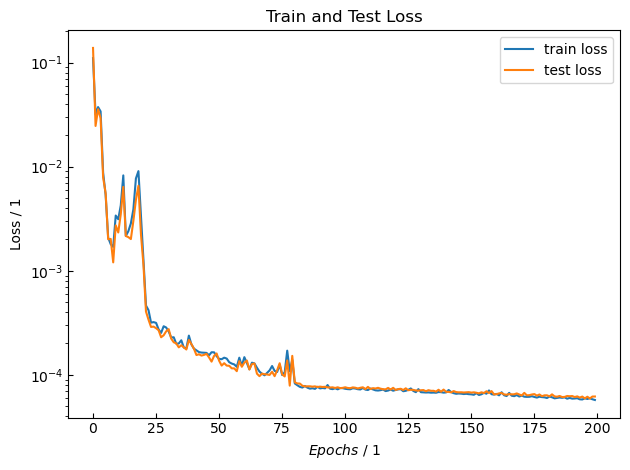

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999576434775971 , R^2(NH3) = 0.9999257034172778
Test Dataset: R^2(H2) = 0.9999470214195332 , R^2(NH3) = 0.9999264238334832
Max Error Training: |x_H2 - x_H2,pred| = 0.013014382254930679 , |x_NH3 - x_NH3,pred| = 0.004773808055864859
Max Error Test: |x_H2 - x_H2,pred| = 0.006351406884661903 , |x_NH3 - x_NH3,pred| = 0.004050904309998826


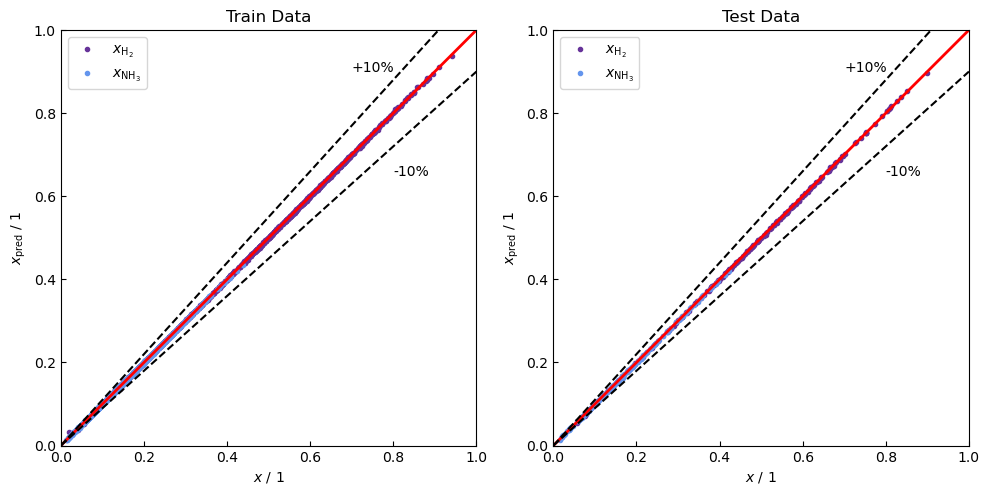

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

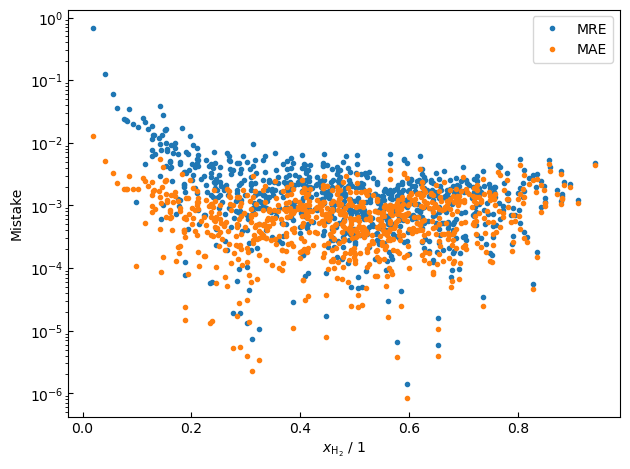

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

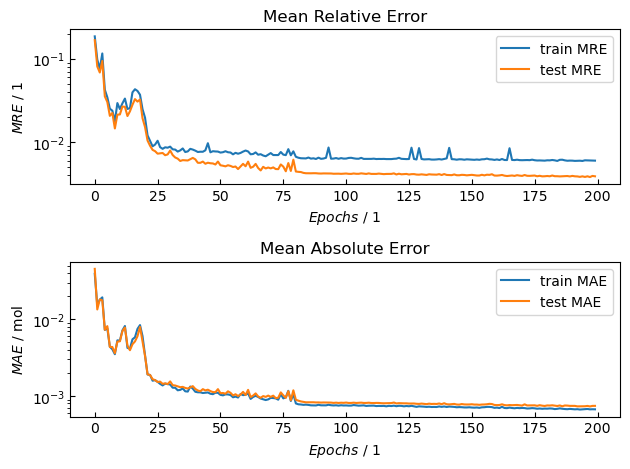

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

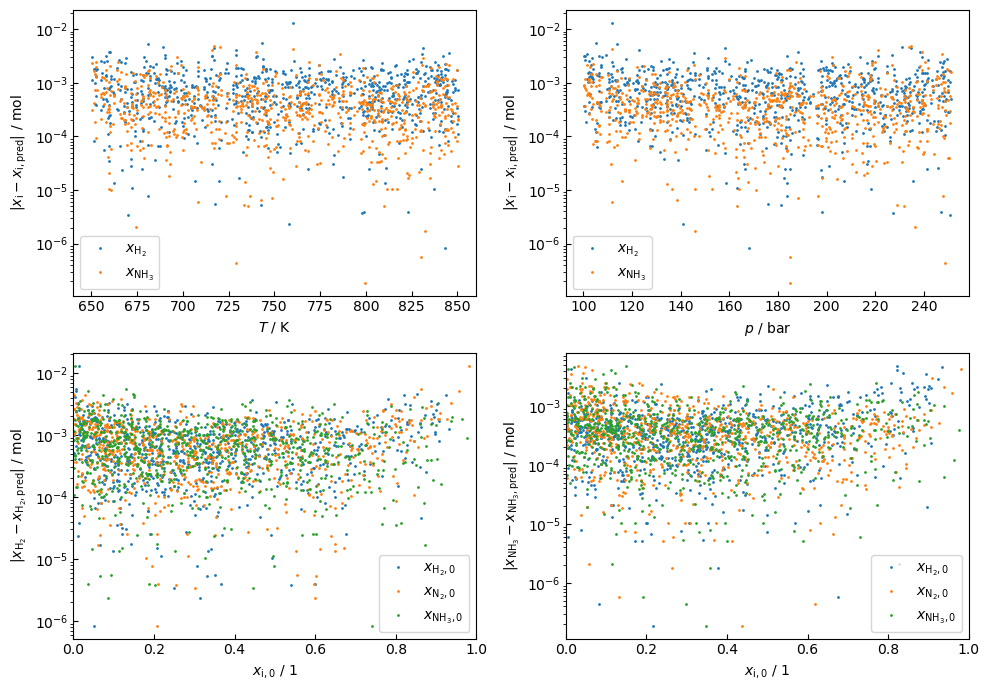

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

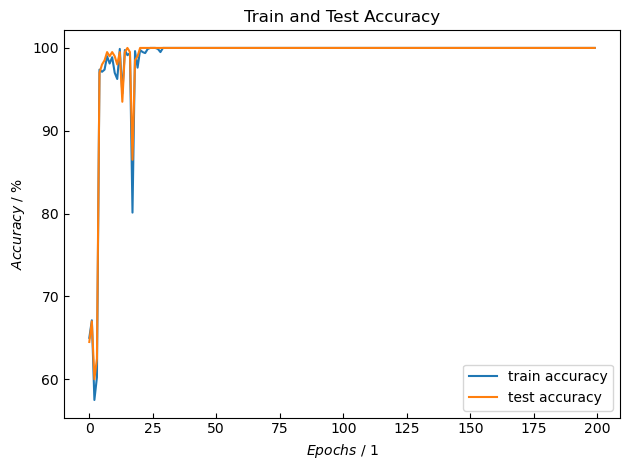

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.03125 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.2462e+00, -1.2972e+00,  2.1539e-02,  1.3482e+00, -1.3991e+00],
        [-1.6779e+00, -5.7737e-01,  1.0921e-01,  7.9630e-01, -9.2106e-01],
        [ 1.9927e-01, -4.2849e-01,  7.6905e-01, -3.5881e-01, -3.8800e-01],
        [-6.2913e-01, -1.6556e+00, -1.0616e+00, -9.6326e-01,  2.0264e+00],
        [ 1.2191e+00, -7.4080e-02, -7.8744e-01,  1.9417e+00, -1.2118e+00],
        [-3.2462e-01,  6.9920e-01,  4.4834e-01,  7.3856e-01, -1.1949e+00],
        [-1.3690e+00, -5.5606e-01, -1.3195e+00, -1.1003e-01,  1.4074e+00],
        [ 5.5695e-01,  1.4321e-01,  1.0718e+00,  2.3066e-01, -1.2876e+00],
        [ 1.3345e+00,  9.1645e-01, -1.4288e-01, -1.8138e-01,  3.2560e-01],
        [-1.1193e+00, -8.0417e-01, -7.0598e-01,  1.2467e+00, -5.8139e-01],
        [ 1.7353e-01,  1.4731e+00,  1.2030e+00, -1.8617e-01, -9.9034e-01],
        [ 1.2829e+00, -4.0059e-01, -9.5703e-01, -1.0960e+00,  2.0594e+00],
        [-5.4461e-01,  4.8240e-01, -2.0080e-01, -7.7678e-01,  9.9099e-01],
        [ 1.6075e+00,  2.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.3225,  0.1950,  0.4587, -0.3634,  0.0169],
         [ 0.0236,  0.1966,  0.2756,  0.0217,  0.1503],
         [ 0.2865, -0.2381, -0.0597,  0.2841, -0.2940],
         [-0.3830,  0.1752,  0.2041,  0.0203, -0.1478],
         [-0.1402,  0.2673,  0.0178, -0.1887,  0.1039],
         [ 0.0230,  0.0835,  0.3723, -0.1180,  0.1586],
         [-0.3851,  0.2877,  0.1094,  0.1302, -0.3497],
         [-0.4075,  0.1920,  0.1627,  0.0276, -0.1338],
         [-0.1707, -0.1158,  0.2480,  0.0087, -0.0623],
         [-0.0696, -0.2803, -0.3098, -0.0885, -0.0593],
         [-0.0138, -0.0951,  0.3338, -0.2969, -0.1070],
         [-0.2384, -0.2497,  0.2469,  0.0589, -0.1448],
         [-0.1671, -0.1413,  0.1591,  0.3150,  0.2883],
         [-0.4174,  0.3176, -0.2309, -0.2928,  0.1323],
         [ 0.2035, -0.1294,  0.3557,  0.4434, -0.2470],
         [-0.3982,  0.1515, -0.1922,  0.0968, -0.3220],
         [ 0.2162,  0.0748,  0.0167, -0.5292, -0.3202],
         [-0.2707,  0.013

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7086, 0.4274, 0.6653, 0.7189, 0.7699],
        [0.1849, 0.1055, 0.1652, 0.7548, 0.6852]])
tensor([[ 0.1061, -0.4009],
        [-0.1898, -0.1719]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1218, -0.4226,  0.6357, -0.9667,  0.3642],
        [-1.5917,  0.8483,  0.4924,  0.2621, -0.7512],
        [ 1.2939,  0.5117, -0.6523, -0.2847,  0.9312],
        [ 0.9667, -1.3365,  1.5060, -1.0696, -0.3848],
        [-0.7719,  0.9031, -0.0169, -0.2096,  0.2308],
        [-0.3724,  1.2186,  0.0358,  0.1376, -0.1758],
        [ 0.9879,  0.0236,  0.1299,  0.7422, -0.8861],
        [ 1.2151,  1.4542,  0.4052,  0.9685, -1.3875],
        [ 0.7930, -0.9739, -1.0534, -0.5780,  1.6245],
        [-0.8014,  0.5139, -0.5077,  1.7835, -1.3246],
        [ 0.5486,  0.5164, -0.8233,  1.3074, -0.5283],
        [ 1.5685,  0.2578,  0.5006, -0.5690,  0.0902],
        [ 0.3444,  0.6332, -1.2000,  0.4484,  0.7194],
        [-0.7409, -0.5610, -1.2218,  2.0842, -0.9312],
        [-0.4450, -0.0399,  0.0185,  0.6903, -0.7237],
        [-0.1906, -0.8907, -0.4660, -1.1702,  1.6533],
        [ 1.2444, -1.6702, -0.9664,  1.3150, -0.3956],
        [ 0.1908, -0.5560, -0.1400, -0.8628,  1.0192],
        [-

#### Histogramme Verteilung von $xi$ und $x{_i}$

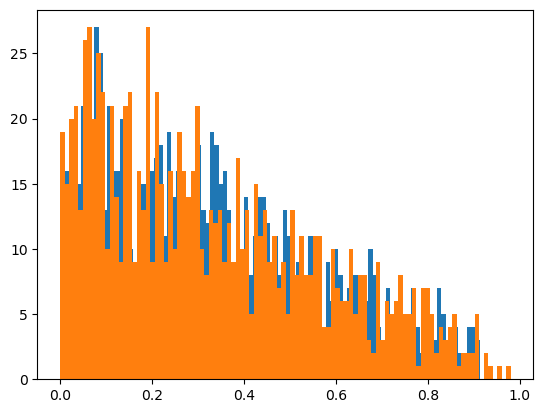

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_028.pth')
# np.savez('data/models/params_005_028.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)